# Get ready

First, download, import, prep packages and such. 

Then, check the file location and import the .csv files. Remove any with empty text fields. 

Save a data frame with all the texts and another with only those texts that mention the keywords of interest. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk


In [2]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics
import datetime
date = datetime.date.today()

import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import matplotlib.pyplot as plt
import string 

import math 

English_punctuation = "-!\"#$%&()'*-–+,./:;<=>?@[\]^_`{|}~''“”"      # Things for removing punctuation, stopwords and empty strings
table_punctuation = str.maketrans('','', English_punctuation)

In [3]:
print(os.listdir("..\\results")  )

files = []
def import_results(input):
    for f in os.listdir(input):
        f = pd.read_csv(input + '\\'+ f,encoding='latin1')
        files.append(f)
    output = pd.concat(files)
    return output

['ESHG2001abstractICHG.csv', 'ESHG2002Abstracts.csv', 'ESHG2003Abstracts.csv', 'ESHG2004.csv', 'ESHG2005Abstracts.csv', 'ESHG2006Abstracts.csv', 'ESHG2007Abstracts.csv', 'ESHG2008Abstracts.csv', 'ESHG2009Abstracts.csv', 'ESHG2010Abstracts.csv', 'ESHG2011Abstracts.csv', 'ESHG2012Abstracts.csv', 'ESHG2013Abstracts.csv', 'ESHG2014Abstracts.csv', 'ESHG2015Abstracts.csv', 'ESHG2016Abstracts.csv', 'ESHG2017 electronic posters.csv', 'ESHG2017 oral presentation.csv', 'ESHG2018 electronic posters.csv', 'ESHG2018 oral presentation.csv', 'ESHG2019 electronic posters.csv', 'ESHG2019 oral presentation.csv', 'ESHG2020 electronic posters.csv', 'ESHG2020 oral presentation.csv', 'ESHG2021 electronic posters.csv', 'ESHG2021 oral presentation.csv']


In [4]:
all_results = import_results("..\\results")
#all_results = all_results.merge(year_04, on='Year')
len(all_results)

34630

In [5]:
year_04 = pd.read_csv('..\\results\\ESHG2004.csv')
year_04 = year_04.iloc[:, [0,1]]
year_04

,Year,Text
0,2004,"L01Multiple Sulfatase Defi ciency: Molecular defect and properties of the autosomal forms of epigenetic mosaicism can be caused by missing enzyme. retrotransposon activity. K. von Figura, M. Maria..."
1,2004,L04Regional differences in genetic testing and counselling in Europe - An overview
2,2004,"L02Biogenesis of mitochondria: Human diseases linked to S. Aymé protein transport, folding and degradation INSERM, Paris, France. W. Neupert"
3,2004,L05Hereditary Breast/Ovarian Cancer risk: international energy present in oxidizable substrates is transduced into energy comparison of the acceptability of Preventive strategies stored in ATP. Mi...
4,2004,L06Variation in prenatal counselling in Europe: the example of highly motile within the cell. Quite a number of genes are involved Klinefelter in these processes which are closely linked to the in...
...,...,...
2200,2004,"C7 A10 in the aetiology of cystinuria, we could not identify any Affected children may have only one episode of illness or multiple mutation in SL"
2201,2004,"C7 A10 in the two families. Nevertheless, there remains recurrences. A common mutation (985A >G) has been identiÜed the possibility that other genes are involved in cystinuria. Further among pa..."
2202,2004,"P0845Inactivation of the spasmolytic trefoil peptide (Tff2) leads In this study, two unrelated MCAD patients, compound heterozygous to increased expression of additional gastroprotective factors..."
2203,2004,"P0843MCDR1 Locus - Screening for candidate genes. functional disturbance in stomach and gut, Tff2-/- constructs do N. Udar1, M. Chalukya1, R. Silva-Garcia1, J. Yeh1, P. Wong1,2, K. Small1 not di..."


In [6]:
all_results = pd.concat([all_results, year_04])
len(all_results)

36835

In [7]:
all_counts_by_year = all_results['Year'].value_counts()
all_counts_by_year = pd.DataFrame(all_counts_by_year)
all_counts_by_year = all_counts_by_year.rename(columns={"Year": "Counts"})
all_counts_by_year = all_counts_by_year.rename_axis('Year').reset_index()
all_counts_by_year = all_counts_by_year.sort_values(by=['Year'])

In [8]:
no_null_texts = all_results[~all_results['Text'].isnull()]
len(no_null_texts)

36184

In [9]:
no_null_counts_by_year = no_null_texts['Year'].value_counts()
no_null_counts_by_year = pd.DataFrame(no_null_counts_by_year)
no_null_counts_by_year = no_null_counts_by_year.rename(columns={"Year": "All"})
no_null_counts_by_year = no_null_counts_by_year.rename_axis('Year').reset_index()
no_null_counts = no_null_counts_by_year.sort_values(by=['Year'])

In [10]:
matched_texts = no_null_texts[no_null_texts['Text'].str.contains('autis|Autis|ASD|Asperger|asperger')]
len(matched_texts)

929

In [11]:
matched_counts_by_year = matched_texts['Year'].value_counts()
matched_counts_by_year = pd.DataFrame(matched_counts_by_year)
matched_counts_by_year = matched_counts_by_year.rename(columns={"Year": "Matches"})
matched_counts_by_year = matched_counts_by_year.rename_axis('Year').reset_index()
matched_counts_by_year = matched_counts_by_year.sort_values(by=['Year'])

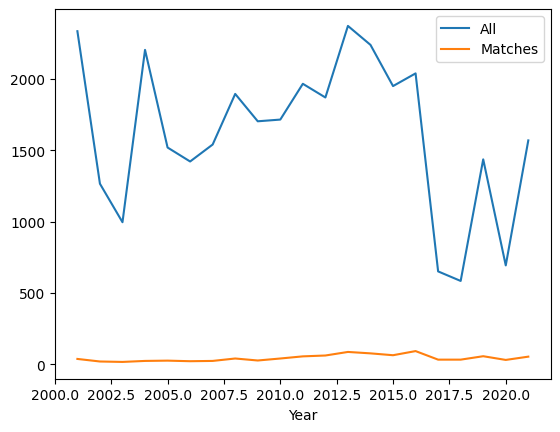

In [12]:
counts_year = no_null_counts_by_year.merge(matched_counts_by_year, on='Year', how='left')
counts_year = counts_year.sort_values(by='Year')
counts_year = counts_year.set_index('Year')
counts_year.plot()
plt.show()

In [13]:
print(counts_year)

         All  Matches
Year                 
2001.0  2336       37
2002.0  1266       19
2003.0   996       16
2004.0  2205       23
2005.0  1520       25
2006.0  1422       21
2007.0  1541       23
2008.0  1896       40
2009.0  1704       26
2010.0  1716       40
2011.0  1967       55
2012.0  1871       61
2013.0  2373       86
2014.0  2240       76
2015.0  1951       63
2016.0  2040       92
2017.0   651       32
2018.0   584       32
2019.0  1437       56
2020.0   693       30
2021.0  1570       53


# Count word frequencies 
## Bag of words

Proceed through the 'bag of words' steps for the data frames with all texts and then again for the data frame with only the texts that mention the keywords of interest. This approach finds word frequencies for all years together. 

In [14]:
def bag_of_words_analysis(input, how_many):
    holding_string = ""
    for text in input['Text']:
        holding_string += text
    holding_string = word_tokenize(holding_string)
    holding_string = [word.lower() for word in holding_string]
    holding_string = [w.translate(table_punctuation) for w in holding_string]
    holding_string = (list(filter(lambda x: x, holding_string)))
    holding_string = [token for token in holding_string if not token.isdigit()]
    holding_string = [token for token in holding_string if token not in stop_words]
    holding_string = [porter.stem(token) for token in holding_string]
    list_for_count = []
    for token in holding_string:
        list_for_count.append(token)
    counts = Counter(list_for_count)
    return counts.most_common(how_many)

In [15]:
bag_of_words_analysis(no_null_texts, 13)

[('gene', 67253),
 ('patient', 58161),
 ('mutat', 55352),
 ('none', 43264),
 ('genet', 41399),
 ('studi', 31669),
 ('use', 27697),
 ('case', 25964),
 ('result', 25136),
 ('associ', 24222),
 ('analysi', 24031),
 ('famili', 23560),
 ('diseas', 23473)]

In [16]:
bag_of_words_analysis(matched_texts, 15)

[('none', 2273),
 ('patient', 2033),
 ('gene', 1887),
 ('genet', 1193),
 ('disord', 1072),
 ('autism', 1065),
 ('delet', 1062),
 ('syndrom', 1052),
 ('mutat', 962),
 ('case', 922),
 ('de', 891),
 ('clinic', 875),
 ('asd', 873),
 ('chromosom', 859),
 ('associ', 843)]

### Word Frequency by year

In [17]:

def track_word_over_time(input, target_word):
    years = input['Year'].drop_duplicates()
    target_counts = []
    for year in years:
        year_bag = ""
        for text in input['Text'][input['Year']==year]:
            year_bag += text
        year_bag = word_tokenize(year_bag)
        year_bag = [word.lower() for word in year_bag]
        year_bag = [w.translate(table_punctuation) for w in year_bag]
        year_bag = (list(filter(lambda x: x, year_bag)))
        year_bag = [token for token in year_bag if not token.isdigit()]
        year_bag = [token for token in year_bag if token not in stop_words]
        year_bag = [porter.stem(token) for token in year_bag]
        list_for_count = []
        for token in year_bag:
            list_for_count.append(token)
        counts = Counter(list_for_count)
        target_counts.append(counts[target_word])
        
    target_word_by_year = pd.DataFrame(list(zip(years, target_counts)), columns = ['Year', str(target_word)])
    return target_word_by_year


In [31]:
ASD = track_word_over_time(no_null_texts, 'asd')
autism = track_word_over_time(no_null_texts, 'autism')
autistic = track_word_over_time(no_null_texts, 'autist')
asperger = track_word_over_time(no_null_texts, 'asperger')

target_words = ASD.merge(autism, on='Year').merge(asperger, on='Year').merge(autistic, on='Year')

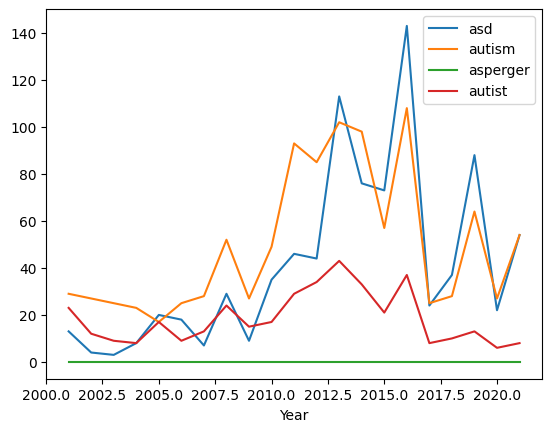

In [32]:
target_words = target_words.set_index('Year')
target_words = target_words.sort_values(by=['Year'])
target_words.plot.line()
plt.show()

In [20]:
diseas = track_word_over_time(no_null_texts, 'diseas')
disord = track_word_over_time(no_null_texts, 'disord')
condition = track_word_over_time(no_null_texts, 'condit')
syndrom = track_word_over_time(no_null_texts, 'syndrom')

target_words_2 = diseas.merge(disord, on='Year').merge(syndrom, on='Year').merge(condition, on='Year')

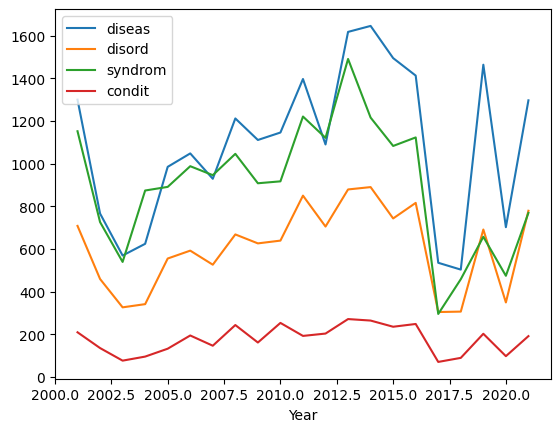

In [21]:
target_words_2 = target_words_2.set_index('Year')
target_words_2 = target_words_2.sort_values(by=['Year'])
target_words_2.plot.line()
plt.show()

### Word frequency by session code
